## AIM: check feature distributions between train & validation set, to see if training data could be overfit due to 'between-brain' differences

In [2]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import mne
# prevent extensive logging
mne.set_log_level('WARNING')

def load_file(file):
    with open(file, 'rb') as handle:
        return pickle.load(handle)

In [2]:
# load features (before feature selection)
df_stat_conn_features = pd.read_pickle(r'D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\TD-BRAIN\TD-BRAIN_extracted_features\df_stat_conn_features.pkl')
df_stat_conn_features = df_stat_conn_features.dropna(subset=['diagnosis'])
df_stat_conn_features.sample(3)

,ID,diagnosis,epoch,EO_l_frontal_delta_std,EO_l_frontal_delta_mean,EO_l_frontal_delta_median,EO_l_frontal_delta_skew,EO_l_frontal_delta_kurt,EO_m_frontal_delta_std,EO_m_frontal_delta_mean,...,ratio_gamma_m_central-r_central,ratio_gamma_m_central-l_posterior,ratio_gamma_m_central-m_posterior,ratio_gamma_m_central-r_posterior,ratio_gamma_r_central-l_posterior,ratio_gamma_r_central-m_posterior,ratio_gamma_r_central-r_posterior,ratio_gamma_l_posterior-m_posterior,ratio_gamma_l_posterior-r_posterior,ratio_gamma_m_posterior-r_posterior
38,sub-87966473,SMC,3,0.404348,-0.157911,-0.164089,-0.614494,0.274403,0.409340,-0.154901,...,1.105426,1.093760,1.101498,1.168655,1.124383,1.104225,1.139648,1.078107,1.142604,1.099247
1995,sub-88057681,OCD,4,0.376226,-0.160259,-0.161636,-0.041570,-0.238622,0.453359,-0.213865,...,1.022645,1.004866,1.014494,1.024243,1.037977,1.069758,1.069564,1.024503,1.014487,1.021855
232,sub-87968449,SMC,5,0.386362,-0.141928,-0.144145,-0.756536,0.858999,0.356116,-0.135858,...,1.068597,1.053602,1.042917,1.063110,1.139098,1.102420,1.072467,1.028319,1.099821,1.058741


In [3]:
# create 3 feature sets [EC, EO, ratio] with column ['ID', 'age', 'gender', 'diagnosis', 'epoch']
df_stat_conn_features_ec = df_stat_conn_features[df_stat_conn_features.columns[~(df_stat_conn_features.columns.str.startswith('EO') | df_stat_conn_features.columns.str.startswith('ratio'))]]
df_stat_conn_features_eo = df_stat_conn_features[df_stat_conn_features.columns[~(df_stat_conn_features.columns.str.startswith('EC') | df_stat_conn_features.columns.str.startswith('ratio'))]]
df_stat_conn_features_ratio = df_stat_conn_features[df_stat_conn_features.columns[~(df_stat_conn_features.columns.str.startswith('EC') | df_stat_conn_features.columns.str.startswith('EO'))]]
print(df_stat_conn_features_ratio.shape)
print(df_stat_conn_features_ec.shape)
print(df_stat_conn_features_eo.shape)

(2700, 408)
(2700, 408)
(2700, 408)


In [4]:
# load training & validation split indices
data_split_indices = load_file(r'D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\Notebooks\data_split_indices.pkl')


### EC features:

In [5]:
# for EC data:
baseline_rest_idxs = data_split_indices['EC'][0]
baseline_val_idxs = data_split_indices['EC'][1]

from sklearn.model_selection import StratifiedGroupKFold
# define numeric columns
numeric_cols = [num_col for num_col in df_stat_conn_features_ec.columns if 'EC' in num_col]
# drop rows with NaN values in numeric columns
df_stat_conn_features_ec = df_stat_conn_features_ec.dropna(subset=numeric_cols)

groups = df_stat_conn_features_ec['ID'].tolist()

X = df_stat_conn_features_ec[numeric_cols]
Y = df_stat_conn_features_ec['diagnosis']

print(f'{df_stat_conn_features_ec.shape = }')
print(f'{len(baseline_rest_idxs) = }, {len(baseline_val_idxs) = }, total: {len(baseline_rest_idxs)+len(baseline_val_idxs)}')

X_traintest = X.iloc[baseline_rest_idxs]
X_val = X.iloc[baseline_val_idxs]
Y_traintest = Y.iloc[baseline_rest_idxs]
Y_val = Y.iloc[baseline_val_idxs]
groups_traintest = [groups[i] for i in baseline_rest_idxs]
groups_val = [groups[i] for i in baseline_val_idxs]

# now splitting the test and training data with seperate StratifiedGroupKFold
desired_test_ratio = 0.20
n_splits = int(1 / desired_test_ratio) # for some reason (?), n_splits also determines the proportion between train & test indices
sgkf = StratifiedGroupKFold(n_splits=n_splits, shuffle=False)  # should shuffle be true?

train_idxs, test_idxs = sgkf.split(X_traintest, Y_traintest, groups_traintest).__next__() # just take the first split
print(f'{len(X_traintest) = }, {len(X_val) = }')
print(f'{len(train_idxs) = }, {len(test_idxs) = }, total: {len(train_idxs)+len(test_idxs)}')

X_train = X_traintest.iloc[train_idxs] # X also includes y values, because they are stored in the Data object
X_test = X_traintest.iloc[test_idxs]
Y_train =Y_traintest.iloc[train_idxs]
Y_test = Y_traintest.iloc[test_idxs]

df_stat_conn_features_ec.shape = (2688, 408)
len(baseline_rest_idxs) = 2148, len(baseline_val_idxs) = 540, total: 2688
len(X_traintest) = 2148, len(X_val) = 540
len(train_idxs) = 1716, len(test_idxs) = 432, total: 2148


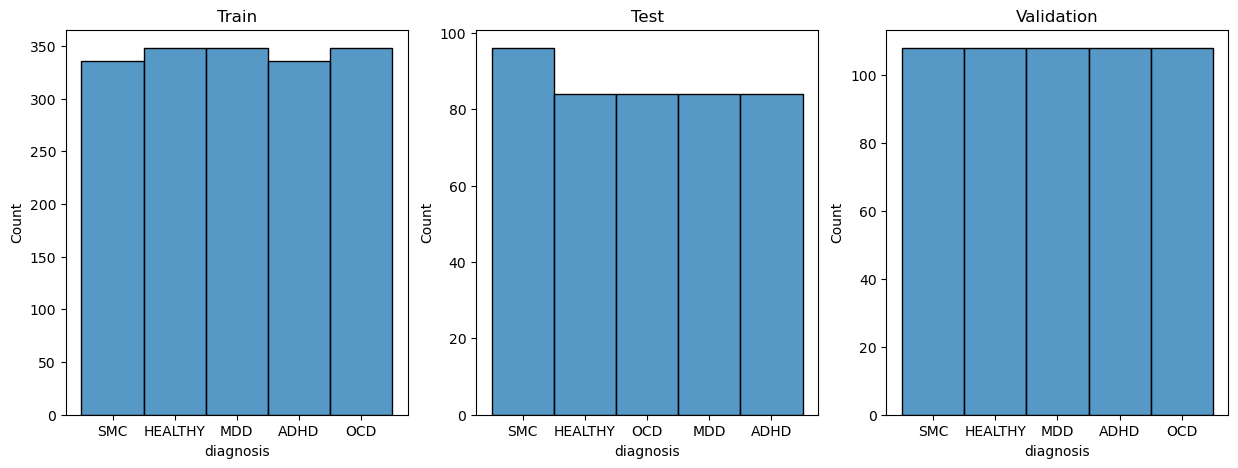

In [6]:
# plot distribution of classes in train, test and validation set
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.histplot(Y_train, ax=ax[0])
sns.histplot(Y_test, ax=ax[1])
sns.histplot(Y_val, ax=ax[2])
ax[0].set_title('Train')
ax[1].set_title('Test')
ax[2].set_title('Validation')
plt.show()


In [23]:
# for each feature; plot the distribution per class in train, test and validation set, and store in pdf
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import math

# Get the list of features
features = X_train.columns
n_features = len(features)

# Define the number of plots per page and the total number of pages
plots_per_page = 5
n_pages = math.ceil(n_features / plots_per_page)

# Create a PdfPages object
with PdfPages('feature_distributions.pdf') as pdf:

    # For each page
    for page in range(n_pages):

        # Create a figure with a subplot for each feature on this page
        fig, axs = plt.subplots(plots_per_page, 1, figsize=(15, 7*plots_per_page))

        # For each plot on this page
        for plot in range(plots_per_page):

            # Calculate the index of the feature for this plot
            i = page*plots_per_page + plot

            # If this feature index is out of range, break the loop
            if i >= n_features:
                break

            # Get the feature name
            feature = features[i]

            # Get the axis for this plot
            ax = axs[plot]

            # Prepare training data
            df_train = pd.concat([X_train[[feature]], Y_train], axis=1)
            df_train['dataset'] = 'train'

            # Prepare validation data
            df_val = pd.concat([X_val[[feature]], Y_val], axis=1)
            df_val['dataset'] = 'val'

            # Prepare test data
            df_test = pd.concat([X_test[[feature]], Y_test], axis=1)
            df_test['dataset'] = 'test'

            # Combine training, validation, and test data
            df = pd.concat([df_train, df_val, df_test])
            df = df.melt(id_vars=['diagnosis', 'dataset'])

            # Create the plot
            sns.violinplot(x='dataset', y='value', hue='diagnosis', split=False, data=df, ax=ax)
            ax.set_title(f'Distribution for {feature} - Train vs Val vs Test')

        # Adjust the layout and save the figure
        fig.tight_layout()
        pdf.savefig(fig)
        plt.close(fig)

#### TFR distribution of participant with kurt outlier

In [9]:
# find ID with highest kurt value

max_kurt_idx = df_stat_conn_features['ratio_m_frontal_theta_kurt'].argmax()
print(f'{max_kurt_idx = }')
print(df_stat_conn_features.iloc[max_kurt_idx]['ratio_m_frontal_theta_kurt'])
ID = df_stat_conn_features.iloc[max_kurt_idx]['ID']
EPOCH = df_stat_conn_features.iloc[max_kurt_idx]['epoch']
print(ID, EPOCH)

max_kurt_idx = 596
257863.56751598194
sub-87974841 9


In [11]:
## Set montage based on channel names and locations provided in Van Dijk et al., (2022) (Copied from Anne van Duijvenbode)
import mne

ch_types = ['eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg',\
           'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', \
           'eog', 'eog', 'eog', 'eog', 'ecg', 'eog', 'emg']

ch_names = ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC3', 'FCz', 'FC4', 'T7', 'C3', 'Cz', 'C4', 'T8', 'CP3', \
            'CPz', 'CP4', 'P7', 'P3', 'Pz', 'P4', 'P8', 'O1', 'Oz', 'O2', 'VPVA', 'VNVB', 'HPHL', 'HNHR', 'Erbs', \
            'OrbOcc', 'Mass']

dict_eeg_channels =  {ch_names[i]: ch_types[i] for i in range(len(ch_types))}

dict_ch_pos = {'Fp1' : [-26.81, 84.06, -10.56],
               'Fp2' : [29.41, 83.74, -10.04],
               'F7'  : [-66.99, 41.69, -15.96],
               'F3'  : [-48.05, 51.87, 39.87],
               'Fz'  : [0.90, 57.01, 66.36],
               'F4'  : [50.38, 51.84, 41.33],
               'F8'  : [68.71, 41.16, -15.31],
               'FC3' : [-58.83, 21.02, 54.82],
               'FCz' : [0.57, 24.63, 87.63],
               'FC4' : [60.29, 21.16, 55.58], 
               'T7'  : [-83.36, -16.52, -12.65], 
               'C3'  : [-65.57, -13.25, 64.98],
               'Cz'  : [0.23, -11.28, 99.81],
               'C4'  : [66.50, -12.80, 65.11],
               'T8'  : [84.44, -16.65, -11.79], 
               'CP3' : [-65.51, -48.48, 68.57],
               'CPz' : [-0.42, -48.77, 98.37], 
               'CP4' : [65.03, -48.35, 68.57], 
               'P7': [-71.46, -75.17, -3.70], 
               'P3'  : [-55.07, -80.11, 59.44], 
               'Pz'  : [-0.87, -82.23, 82.43],
               'P4'  : [53.51, -80.13, 59.40], 
               'P8' : [71.10, -75.17, -3.69], 
               'O1'  : [-28.98, -114.52, 9.67],  
               'Oz'  : [-1.41, -117.79, 15.84],
               'O2'  : [26.89, -114.68, 9.45]
              }

dict_ch_pos_m = {'Fp1' : [-0.2681, 0.8406, -0.1056],
               'Fp2' : [0.2941, 0.8374, -0.1004],
               'F7'  : [-0.6699, 0.4169, -0.1596],
               'F3'  : [-0.4805, 0.5187, 0.3987],
               'Fz'  : [0.0090, 0.5701, 0.6636],
               'F4'  : [0.5038, 0.5184, 0.4133],
               'F8'  : [0.6871, 0.4116, -0.1531],
               'FC3' : [-0.5883, 0.2102, 0.5482],
               'FCz' : [0.0057, 0.2463, 0.8763],
               'FC4' : [0.6029, 0.2116, 0.5558], 
               'T7'  : [-0.8336, -0.1652, -0.1265], 
               'C3'  : [-0.6557, -0.1325, 0.6498],
               'Cz'  : [0.0023, -0.1128, 0.9981],
               'C4'  : [0.6650, -0.1280, 0.6511],
               'T8'  : [0.8444, -0.1665, -0.1179], 
               'CP3' : [-0.6551, -0.4848, 0.6857],
               'CPz' : [-0.042, -0.4877, 0.9837], 
               'CP4' : [0.6503, -0.4835, 0.6857], 
               'P7'  : [-0.7146, -0.7517, -0.0370], 
               'P3'  : [-0.5507, -0.8011, 0.5944], 
               'Pz'  : [-0.0087, -0.8223, 0.8243],
               'P4'  : [0.5351, -0.8013, 0.5940], 
               'P8'  : [0.7110, -0.7517, -0.0369], 
               'O1'  : [-0.2898, -1.1452, 0.0967],  
               'Oz'  : [-0.0141, -1.1779, 0.1584],
               'O2'  : [0.2689, -1.1468, 0.0945]
              }

dict_ch_pos_array = {'Fp1' : np.array([-0.02681, 0.08406, -0.01056]),
               'Fp2' : np.array([0.02941, 0.08374, -0.01004]),
               'F7'  : np.array([-0.06699, 0.04169, -0.01596]),
               'F3'  : np.array([-0.04805, 0.05187, 0.03987]),
               'Fz'  : np.array([0.00090, 0.05701, 0.06636]),
               'F4'  : np.array([0.05038, 0.05184, 0.04133]),
               'F8'  : np.array([0.06871, 0.04116, -0.01531]),
               'FC3' : np.array([-0.05883, 0.02102, 0.05482]),
               'FCz' : np.array([0.00057, 0.02463, 0.08763]),
               'FC4' : np.array([0.06029, 0.02116, 0.05558]), 
               'T7'  : np.array([-0.08336, -0.01652, -0.01265]), 
               'C3'  : np.array([-0.06557, -0.01325, 0.06498]),
               'Cz'  : np.array([0.000023, -0.01128, 0.09981]),
               'C4'  : np.array([0.06650, -0.01280, 0.06511]),
               'T8'  : np.array([0.08444, -0.01665, -0.01179]), 
               'CP3' : np.array([-0.06551, -0.04848, 0.06857]),
               'CPz' : np.array([-0.0042, -0.04877, 0.09837]), 
               'CP4' : np.array([0.06503, -0.04835, 0.06857]), 
               'P7'  : np.array([-0.07146, -0.07517, -0.00370]), 
               'P3'  : np.array([-0.05507, -0.08011, 0.05944]), 
               'Pz'  : np.array([-0.00087, -0.08223, 0.08243]),
               'P4'  : np.array([0.05351, -0.08013, 0.05940]), 
               'P8'  : np.array([0.07110, -0.07517, -0.00369]), 
               'O1'  : np.array([-0.02898, -0.11452, 0.00967]),  
               'Oz'  : np.array([-0.00141, -0.11779, 0.01584]),
               'O2'  : np.array([0.02689, -0.11468, 0.00945])
              }

# channel groupings (left/mid/right)
l_frontal = ['F3', 'FC3']
m_frontal = ['Fz', 'FCz']
r_frontal = ['F4', 'FC4']
l_central = ['C3', 'CP3']
m_central = ['Cz', 'CPz']
r_central = ['C4', 'CP4']
l_posterior = ['P3', 'O1'] 
m_posterior = ['Pz', 'Oz'] 
r_posterior = ['P4', 'O2'] 
channel_groups = {
    'l_frontal': l_frontal,
    'm_frontal': m_frontal,
    'r_frontal': r_frontal,
    'l_central': l_central,
    'm_central': m_central,
    'r_central': r_central,
    'l_posterior': l_posterior,
    'm_posterior': m_posterior,
    'r_posterior': r_posterior
}

# define (5) frequencies of interest for TFR per frequency band
delta = np.array([1, 1.5, 2, 2.5, 3]) # starting at one because of high-pass filter
theta = np.array([4, 4.75, 5.5, 6.25, 7])
alpha = np.array([8, 9, 10, 11, 12])
beta = np.array([13, 17.25, 21.5, 25.75, 30])
gamma = np.array([42, 54, 66, 78, 90]) 
bands = {'delta': delta, 'theta': theta, 'alpha': alpha, 'beta': beta, 'gamma': gamma}


## Create montage
montage = mne.channels.make_dig_montage(ch_pos = dict_ch_pos_array, coord_frame = 'head')

# Create info object for MNE
info = mne.create_info(ch_names=ch_names, ch_types=ch_types, sfreq=500)
info.set_montage(montage=montage, on_missing= 'raise')
# print(info)

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,29 points
Good channels,"26 EEG, 5 EOG, 1 ECG, 1 EMG"
Bad channels,None
EOG channels,"VPVA, VNVB, HPHL, HNHR, OrbOcc"
ECG channels,Erbs
Sampling frequency,500.00 Hz
Highpass,0.00 Hz
Lowpass,250.00 Hz


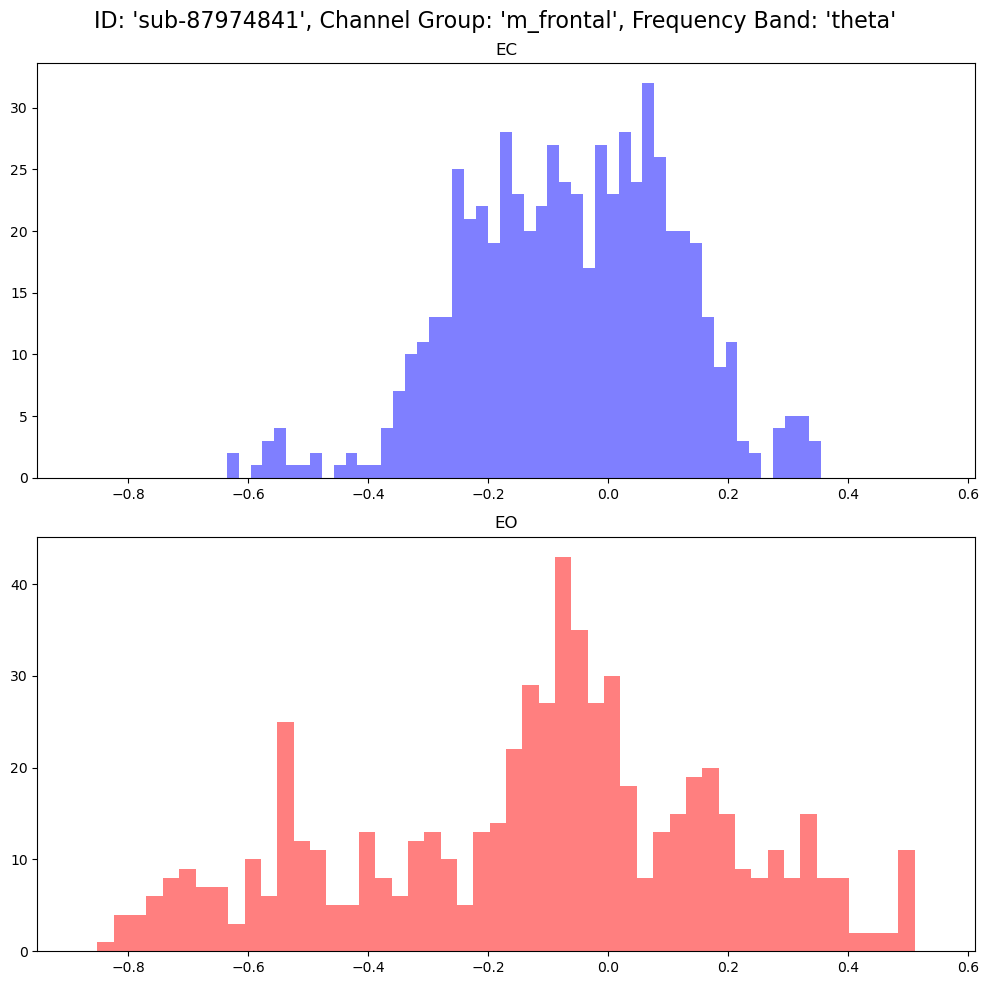

In [25]:
# retrieve TFR of this ID
import os
import scipy
from mne.time_frequency import tfr_multitaper
import matplotlib.pyplot as plt
# calculate variance in power per freq band and per channel group for each file and store in dataframe
eeg_dir = "D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\TD-BRAIN\TDBRAIN-dataset-derivatives\derivatives\preprocessed"

#exlude_dirs = ['preprocessed', 'results_manuscript', 'adhd_sample'] # exclude these directories
sample_ids = ID # list of participants to include
#sample_ids = ['sub-87966293', 'sub-87966337']

# Create a figure with two subplots (one for each condition)
fig, axs = plt.subplots(2, 1, figsize=(10, 10))
fig.suptitle(f"ID: 'sub-87974841', Channel Group: 'm_frontal', Frequency Band: 'theta'", fontsize=16)

# Initialize empty lists to store tfr_mt_avg for each condition
tfr_mt_avg_EC = []
tfr_mt_avg_EO = []

# counter for progress
count = 1
if count == 1:
    total_files = 0
    for _, dirs, files in os.walk(eeg_dir):
        #dirs[:] = [d for d in dirs if d not in exlude_dirs] # exclude directories
        total_files += len([file for file in files if any(sample_id in file for sample_id in sample_ids) and '.npy' in file and 'ses-1' in file and 'BAD' not in file])

for subdir, dirs, files in os.walk(eeg_dir): # iterate through all files
    #dirs[:] = [d for d in dirs if d not in exlude_dirs] # exclude directories
    for file in files:
        if 'sub-87974841' in file: # filter participants to include
            if 'ses-1' in file and '.npy' in file and 'BAD' not in file: # filter first session, .npy files, and non-bad files
                filepath = os.path.join(subdir, file) # path to eeg file

                # needs specific info object, because has one less channel
                info = mne.create_info(ch_names=ch_names[:32], ch_types=ch_types[:32], sfreq=500)
                info.set_montage(montage=montage, on_missing= 'raise')

                preprocessed_eeg = np.load(filepath, allow_pickle = True)
                raw = mne.io.RawArray(np.squeeze(preprocessed_eeg['data']), info)

                # epoch the data
                epochs = mne.make_fixed_length_epochs(raw, duration = 9.95, overlap = 0)
                # print(epochs[EPOCH])
                if 'EC' in file:
                    cond = 'EC'
                if 'EO' in file:
                    cond = 'EO'
                
                # calculate TFR per band and channel group using multitaper convolution
                
                tfr_mt = tfr_multitaper(
                    epochs[EPOCH],
                    freqs=bands['theta'],
                    n_cycles=(bands['theta'] / 2),
                    time_bandwidth=4, # just random for now
                    use_fft=True,
                    return_itc=False,
                    average=False,
                    decim=8, # decim reduces sampling rate of the tf decomposition by the defined factor
                    n_jobs=-1,
                    picks=channel_groups['m_frontal'])
                tfr_mt.apply_baseline((None, None), mode='logratio') # baseline correction, (None, None) = whole epoch

                # average signal over channels and frequencies
                tfr_mt_avg = np.mean(tfr_mt.data, axis = (0, 1, 2)) # average over channels and frequencies

                # Store tfr_mt_avg based on the condition
                if cond == 'EC':
                    tfr_mt_avg_EC.append(tfr_mt_avg)
                elif cond == 'EO':
                    tfr_mt_avg_EO.append(tfr_mt_avg)

# Flatten the arrays into a single list
tfr_mt_avg_EC_flat = np.concatenate([np.ravel(arr) for arr in tfr_mt_avg_EC])
tfr_mt_avg_EO_flat = np.concatenate([np.ravel(arr) for arr in tfr_mt_avg_EO])

# Calculate the minimum and maximum values across both conditions
min_val = min(np.min(tfr_mt_avg_EC_flat), np.min(tfr_mt_avg_EO_flat)) - 0.1
max_val = max(np.max(tfr_mt_avg_EC_flat), np.max(tfr_mt_avg_EO_flat)) + 0.1

# Plot histograms
axs[0].hist(tfr_mt_avg_EC, bins=50, color='b', alpha=0.5)
axs[0].set_title('EC')
axs[0].set_xlim([min_val, max_val])  # Set the limits for the x-axis

axs[1].hist(tfr_mt_avg_EO, bins=50, color='r', alpha=0.5)
axs[1].set_title('EO')
axs[1].set_xlim([min_val, max_val])  # Set the limits for the x-axis

plt.tight_layout()
plt.show()


### Stat features min max before/after standardization

In [7]:
df_stat_features = pd.read_pickle(r'D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\TD-BRAIN\TD-BRAIN_extracted_features\df_stat_features.pkl')
df_stat_features.sample(5)

,ID,age,gender,diagnosis,epoch,EO_l_frontal_delta_std,EO_l_frontal_delta_mean,EO_l_frontal_delta_median,EO_l_frontal_delta_skew,EO_l_frontal_delta_kurt,...,ratio_r_posterior_beta_std,ratio_r_posterior_beta_mean,ratio_r_posterior_beta_median,ratio_r_posterior_beta_skew,ratio_r_posterior_beta_kurt,ratio_r_posterior_gamma_std,ratio_r_posterior_gamma_mean,ratio_r_posterior_gamma_median,ratio_r_posterior_gamma_skew,ratio_r_posterior_gamma_kurt
4276,sub-88044141,14.43,1.0,ADHD,5,0.101034,0.115040,0.115040,1.892093,4.288898,...,1.763020,3.049328,2.464403,2.034447,6.314394,0.187085,0.297623,0.242902,1.884464,4.826757
5516,sub-88054357,60.79,0.0,MDD,9,0.037498,0.054091,0.054091,2.062608,5.116542,...,1.143702,1.521516,1.173674,2.753504,9.612939,0.305309,0.592611,0.513578,1.684555,3.716727
3958,sub-88041529,8.10,1.0,ADHD,11,0.081567,0.104941,0.104941,1.300339,1.369006,...,1.306158,1.828767,1.524363,3.010816,12.193095,1.246829,1.887040,1.544923,2.190462,8.390227
1991,sub-88015881,10.34,1.0,ADHD,12,0.101199,0.114011,0.114011,1.434566,1.862635,...,0.962013,1.206119,0.946677,2.657102,8.257501,1.416765,2.089394,1.567704,2.006490,5.062543
4009,sub-88041941,47.59,1.0,HEALTHY,2,0.049997,0.058558,0.058558,2.160685,5.251956,...,0.905832,1.332264,1.097563,1.817281,4.726100,0.342790,0.730382,0.668857,1.632512,5.567844


In [4]:
# standardize all numerical features = containing 'EC', 'EO' or 'ratio
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
numeric_cols = [col for col in df_stat_features.columns if 'EC' in col or 'EO' in col or 'ratio' in col]
df_stat_features[numeric_cols] = scaler.fit_transform(df_stat_features[numeric_cols])

In [5]:
# Calculate min and max values for each column
df_min_max = df_stat_features[numeric_cols].agg(['min', 'max']).transpose().reset_index()

# Rename the columns
df_min_max.columns = ['feature', 'min', 'max']

df_min_max.to_csv('min_max_new_stat_features_standarized.csv', index=False)

### Stat features distributions after standardization

In [8]:
# plot distribution of each feature as a histogram
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.backends.backend_pdf import PdfPages

numeric_cols = [col for col in df_stat_features.columns if 'EC' in col or 'EO' in col or 'ratio' in col]
# Create a PdfPages object
with PdfPages('standardized_feature_distributions.pdf') as pdf:
    # Iterate over numeric columns
    for i in range(0, len(numeric_cols), 5):
        # Create a new figure for each set of 5 features
        plt.figure(figsize=(10, 10))
        
        for j in range(5):
            if i+j < len(numeric_cols):
                plt.subplot(5, 1, j+1)
                sns.histplot(df_stat_features[numeric_cols[i+j]], kde=False)
                plt.title(numeric_cols[i+j])
        
        # Tight layout often produces nice results
        # but requires the title to be spaced accordingly
        plt.tight_layout()
        plt.subplots_adjust(top=0.88)
        
        # Save the current figure to the pdf
        pdf.savefig()
        plt.close()

### Check how many type of features were selected after BORUTA

In [9]:
df_selected_stat_features = pd.read_pickle(r'D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\TD-BRAIN\TD-BRAIN_extracted_features\df_selected_stat_features.pkl')
df_selected_stat_features.sample(5)

,ID,epoch,diagnosis,EC_l_frontal_delta_mean,EC_l_frontal_delta_median,EC_l_frontal_theta_std,EC_l_frontal_theta_mean,EC_l_frontal_theta_median,EC_l_frontal_alpha_std,EC_l_frontal_alpha_mean,...,ratio_r_posterior_delta_median,ratio_r_posterior_theta_mean,ratio_r_posterior_theta_median,ratio_r_posterior_alpha_median,ratio_r_posterior_beta_std,ratio_r_posterior_beta_mean,ratio_r_posterior_beta_median,ratio_r_posterior_gamma_std,ratio_r_posterior_gamma_mean,ratio_r_posterior_gamma_median
7502,sub-88073745,3,OCD,0.082426,0.082426,0.024169,0.057393,0.057393,0.019095,0.037703,...,1.129591,1.474098,1.097098,1.306031,1.559515,2.021678,1.463368,0.432366,0.931000,0.811392
2299,sub-88020153,8,MDD,0.039032,0.039032,0.042975,0.064556,0.064556,0.047681,0.078258,...,1.050784,1.534238,1.142515,1.453643,0.658479,1.083474,0.944178,0.318851,0.553693,0.481104
1036,sub-87974617,5,HEALTHY,0.083533,0.083533,0.032044,0.051309,0.051309,0.034393,0.056985,...,0.801766,1.103091,0.813802,2.592239,1.319254,2.064758,1.698542,2.336951,3.083102,2.464096
1260,sub-87980329,1,HEALTHY,0.090418,0.090418,0.030452,0.058458,0.058458,0.022259,0.039182,...,0.753935,1.439056,1.026323,2.025186,2.370755,3.697928,3.245544,4.307515,7.596018,6.823311
2762,sub-88025917,3,ADHD,0.095047,0.095047,0.032488,0.055577,0.055577,0.036704,0.044704,...,0.778382,1.283388,0.849353,2.857285,2.684309,2.825066,1.928233,0.477187,0.632552,0.499056


In [13]:
# Count how many columns there are containing each of the frequency bands, each of the channel groups and each of the different statistical measures
# Count how many columns there are containing each of the frequency bands, each of the channel groups and each of the different statistical measures
# Create lists for EC, EO and ratio features
features = ['EC', 'EO', 'ratio']

# Create an empty dictionary to store the counts
counts = {'feature': [], 'band': [], 'channel_group': [], 'stat': [], 'count': []}
stats = ['mean', 'std', 'median', 'kurt', 'skew']

# Iterate over the features, frequency bands, channel groups, and statistical measures
for feature in features:
    for band in bands:
        for channel_group in channel_groups:
            for stat in stats:
                # Count how many columns contain this combination of feature, band, channel group, and statistical measure
                count = sum([feature in col and band in col and channel_group in col and stat in col for col in df_selected_stat_features.columns])
                
                # Store the counts in the dictionary
                counts['feature'].append(feature)
                counts['band'].append(band)
                counts['channel_group'].append(channel_group)
                counts['stat'].append(stat)
                counts['count'].append(count)

# Create a DataFrame from the dictionary
df_counts = pd.DataFrame(counts)

# groupby feature, band, channel_group, stat and sum the counts
for feature in features:
    df_counts_grouped_band = df_counts[df_counts['feature'] == feature].groupby(['band']).sum().reset_index()
    print(f"For {feature} features:")
    print(df_counts_grouped_band.loc[:,['band', 'count']].to_string(index=False))
    print("\n")

    df_counts_grouped_channel_group = df_counts[df_counts['feature'] == feature].groupby(['channel_group']).sum().reset_index()
    print(df_counts_grouped_channel_group.loc[:,['channel_group', 'count']].to_string(index=False))
    print("\n")

    df_counts_grouped_stat = df_counts[df_counts['feature'] == feature].groupby(['stat']).sum().reset_index()
    print(df_counts_grouped_stat.loc[:,['stat', 'count']].to_string(index=False))
    print("\n")

    # Calculate and print the total count for the feature
    total_count = df_counts[df_counts['feature'] == feature]['count'].sum()
    print(f"Total count for {feature} features: {total_count}\n")

For EC features:
 band  count
alpha     28
 beta     27
delta     26
gamma     39
theta     27


channel_group  count
    l_central     16
    l_frontal     15
  l_posterior     17
    m_central     16
    m_frontal     16
  m_posterior     16
    r_central     16
    r_frontal     17
  r_posterior     18


  stat  count
  kurt      3
  mean     45
median     45
  skew     10
   std     44


Total count for EC features: 147

For EO features:
 band  count
alpha     24
 beta     27
delta     25
gamma     34
theta     25


channel_group  count
    l_central     16
    l_frontal     16
  l_posterior     14
    m_central     12
    m_frontal     15
  m_posterior     15
    r_central     15
    r_frontal     16
  r_posterior     16


  stat  count
  kurt      0
  mean     45
median     45
  skew      7
   std     38


Total count for EO features: 135

For ratio features:
 band  count
alpha      6
 beta     12
delta      7
gamma     25
theta     16


channel_group  count
    l_central      7
